In [111]:
import os
import pandas as pd
import numpy as np
import pickle

from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import eli5
from IPython.display import display_html

from sklearn.feature_selection import RFECV

In [2]:
SEED = 42

In [3]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Загрузка данных**

In [4]:
train_data_path = 'Data/train_sessions.csv'
test_data_path = 'Data/test_sessions.csv'
dict_path = 'Data/site_dic.pkl'

In [5]:
raw_train = pd.read_csv(train_data_path)
raw_train.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [6]:
raw_test = pd.read_csv(test_data_path)
raw_test.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,...,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
1,2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,...,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
2,3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,...,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
3,4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,...,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
4,5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,...,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [7]:
with open(dict_path, 'rb') as file:
    site2id_dict = pickle.load(file)

In [8]:
print(raw_train.shape, raw_test.shape)

(253561, 22) (82797, 21)


https://www.kaggle.com/kashnitsky/model-validation-in-a-competition#Submission-3:-Example-of-overfitting

### Bag of words (TfidfVectorizer) preparation

In [9]:
def prepare_tfidf_features(train_df, test_df, site_dict, vectorizer_params):
    site_columns = ['site{}'.format(i) for i in range(1, 11)]
    time_columns = ['time{}'.format(i) for i in range(1, 11)]
    
    # Make inverse dict
    id2site_dict = {v: k for (k, v) in site2id_dict.items()}
    id2site_dict[0] = 'unknown'
    
    # Sort values by initial session time to avoid a data leak during cross-validation.
    # Prepare df for mapping
    train_df = train_df.sort_values('time1').reset_index(drop = True)
    
    train_sessions = train_df[site_columns].fillna(0).astype('int').apply(lambda row:
                                                                          ' '.join([id2site_dict[i] for i in row]), axis = 1).tolist()
    test_sessions = test_df[site_columns].fillna(0).astype('int').apply(lambda row:
                                                                          ' '.join([id2site_dict[i] for i in row]), axis = 1).tolist()
    # encoding
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train_tfidf =  vectorizer.fit_transform(train_sessions)
    X_test_tfidf = vectorizer.transform(test_sessions)
    
    tfidf_feature_names = vectorizer.get_feature_names() 
    
    y_train = train_df ['target'].astype('int').to_numpy()
    
    for column_name in time_columns:
        train_df[column_name] = pd.to_datetime(train_df[column_name])
        test_df[column_name] = pd.to_datetime(test_df[column_name])
        
    X_train_time = train_df[time_columns]
    X_test_time = test_df[time_columns]
    
    
    
    return list(tfidf_feature_names), X_train_tfidf, X_test_tfidf, X_train_time, X_test_time, y_train

In [10]:
vectorizer_params={'ngram_range': (1, 5), 
                    'max_features': 50000,
                    'tokenizer': lambda s: s.split()}

In [11]:
%%time
temp_output = prepare_tfidf_features(raw_train, raw_test, site_dict = site2id_dict, 
                                     vectorizer_params = vectorizer_params)
tfidf_feature_names, X_train_tfidf, X_test_tfidf, X_train_time, X_test_time, y_train = temp_output

CPU times: user 25 s, sys: 545 ms, total: 25.5 s
Wall time: 22.6 s


In [12]:
X_train_time.head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
2,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
3,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20
4,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22


### Naive linear model

In [13]:
cross_val_time_split = TimeSeriesSplit(n_splits = 5)

In [14]:
logit = LogisticRegression(random_state = SEED, n_jobs = -1, solver = 'lbfgs')

In [15]:
naive_cross_val_score = cross_val_score(logit, X_train_tfidf, y_train, 
                                        cv = cross_val_time_split, scoring = 'roc_auc')

In [16]:
print('roc-auc scores by folds: ', naive_cross_val_score )
print('mean roc-auc score: ', naive_cross_val_score.mean())

roc-auc scores by folds:  [0.69952516 0.81280791 0.88185376 0.87918897 0.92839721]
mean roc-auc score:  0.8403546028149196


In [17]:
logit.fit(X_train_tfidf, y_train)
naive_logit_predictions = logit.predict_proba(X_test_tfidf)[:, 1]

In [18]:
write_to_submission_file(naive_logit_predictions, 'Predictions/naive_logit_predictions.csv')

Result: 0.91803

### EDA

In [19]:
viz_data = X_train_time.copy()
viz_data['target'] = y_train

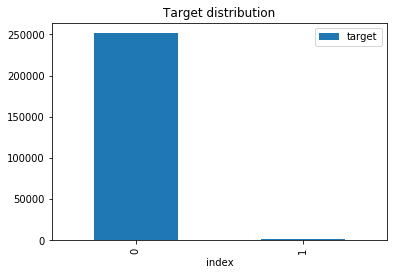

In [20]:
viz_data['target'].value_counts().reset_index().plot.bar(x = 'index', y = 'target')
plt.title('Target distribution')
plt.show()

In [21]:
def plot_countplots(feature_name, suptitle, figsize = (10, 5)):
    fig, axs = plt.subplots(1, 2, figsize = figsize) 
    axs = axs.ravel()

    for target, ax in enumerate(axs):
        sns.countplot(viz_data[viz_data['target'] == target][str(feature_name)], ax = ax)
        ax.set_title('Target: {}'.format(target))
    fig.suptitle(str(suptitle))
    plt.show()    

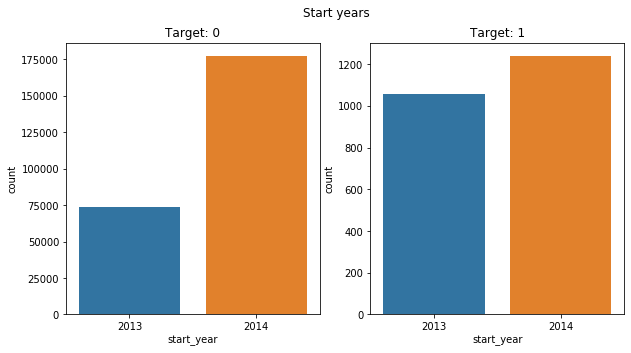

In [22]:
viz_data['start_year'] = viz_data['time1'].dt.year
plot_countplots('start_year', 'Start years')

**Time features**

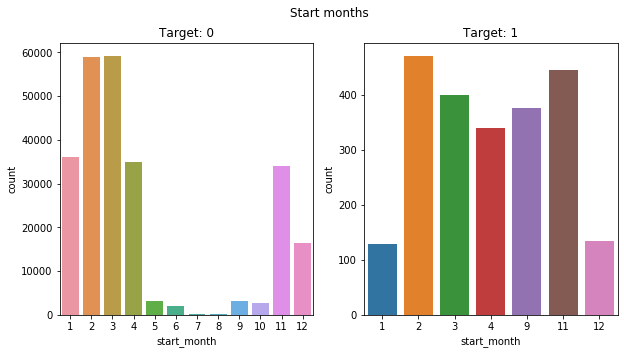

In [23]:
viz_data['start_month'] = viz_data['time1'].dt.month
plot_countplots('start_month', 'Start months')

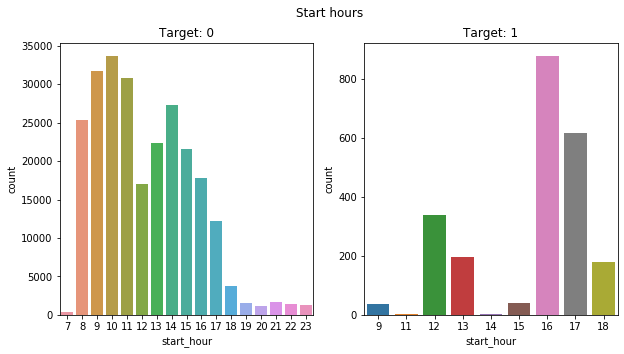

In [24]:
viz_data['start_hour'] = viz_data['time1'].dt.hour
plot_countplots('start_hour', 'Start hours')

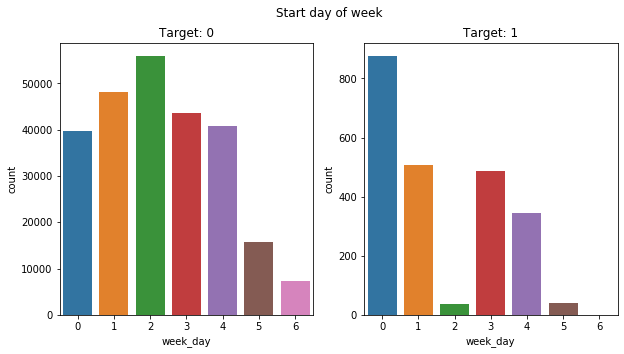

In [25]:
viz_data['week_day'] = viz_data['time1'].dt.weekday
plot_countplots('week_day', 'Start day of week')

**Text features**

In [26]:
###############

### Feature engineering

In [27]:
time_columns = ['time{}'.format(i) for i in range(1, 11)]

In [89]:
def prepare_time_features(df):
    # add start times features
    df = df.copy()
    start_month = df['time1'].dt.month
    start_day = df['time1'].dt.day
    start_hour = df['time1'].dt.hour
    start_day_of_week = df['time1'].dt.weekday
    
    df['sin_month'] = np.sin(2*np.pi*start_month/12)
    df['cos_month'] = np.cos(2*np.pi*start_month/12)
    
#     df['sin_day'] = np.sin(2*np.pi*start_day/31)
#     df['cos_day'] = np.cos(2*np.pi*start_day/31)
    
    df['sin_hour'] = np.sin(2*np.pi*start_hour/24)
    df['cos_hour'] = np.cos(2*np.pi*start_hour/24)
    
    df['sin_day_of_week'] = np.sin(2*np.pi*start_day_of_week/7)
    df['cos_day_of_week'] = np.cos(2*np.pi*start_day_of_week/7)
    
    # add time diffs
    time_diffs =  (np.diff(df[time_columns ].to_numpy(), axis = 1)/1e9).astype(int)
    time_diffs = np.where(time_diffs < 0, 0, time_diffs)
    time_diffs = pd.DataFrame(time_diffs, columns = ['diff{}'.format(i) for i in range(1, 10)])
    df = pd.concat([df, time_diffs], axis = 1)
    
    #sessin length
    df['sessin_length'] = ((np.max(df[time_columns], axis = 1) - np.min(df[time_columns], 
                                                                       axis = 1))/1e9).astype(int)    
    
    df = df.drop(time_columns, axis = 1)
    return df 
    

In [90]:
X_train_time_prep = prepare_time_features(X_train_time)
X_test_time_prep = prepare_time_features(X_test_time)

In [91]:
scaler = StandardScaler()
X_train_time_sc = scaler.fit_transform(X_train_time_prep)
X_test_time_sc = scaler.transform(X_test_time_prep)

In [92]:
X_train = sparse.hstack([X_train_tfidf, sparse.csr_matrix(X_train_time_sc)])
X_test = sparse.hstack([X_test_tfidf, sparse.csr_matrix(X_test_time_sc)])

feature_names = tfidf_feature_names + X_train_time_prep.columns.to_list()

### Build model with new features

In [106]:
def train_and_predict(model, X_train, y_train, X_test, feature_names, params = {},
                      cv_method = cross_val_time_split, scoring = 'roc_auc', top_n_features = 30, 
                      submission_path = None, return_eli5_weights = False):
    model = model(**params)
    cv_scores = cross_val_score(model, X_train, y_train, cv = cv_method, scoring = scoring)
    
    print('cv scores:', cv_scores)
    print('cv mean: {}, cv std: {}'.format(cv_scores.mean(), cv_scores.std()))
    
    model.fit(X_train, y_train)
    display_html(eli5.show_weights(estimator = model, 
                                   feature_names = feature_names, 
                                   top = top_n_features)) 
    if return_eli5_weights:
        pass  #return dataframe
    
    if submission_path is not None:
        predictions = model.predict_proba(X_test)[:, 1]
        write_to_submission_file(predictions, submission_path)
        
        
    

In [107]:
logistic_params = {'random_state': SEED, 
                   'n_jobs': -1, 
                   'solver': 'lbfgs'}

In [110]:
train_and_predict(LogisticRegression, X_train, y_train, X_test, feature_names, params = logistic_params,
                  cv_method = TimeSeriesSplit(n_splits = 5), 
                  submission_path = 'Predictions/logit_predictions_time_features.csv')

cv scores: [0.7737245  0.81692156 0.94651021 0.92930452 0.97946894]
cv mean: 0.8891859455236195, cv std: 0.07949852171147362


Weight?,Feature
+5.382,www.info-jeunes.net
+5.326,vk.com
+4.871,www.melty.fr
+4.863,youwatch.org
+4.713,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.416,fr.glee.wikia.com
+4.260,www.banque-chalus.fr
+4.232,www.express.co.uk
+4.021,www.audienceinsights.net
+4.003,media-1.melty.fr


0.8443024490552782 - month

0.8511126683161745 - month + day of week

0.8891859455236195 - month + day of week + hour

In [145]:
##############################################################################

*Try RFECV*

In [118]:
logit = LogisticRegression(**logistic_params)
selector = RFECV(logit , cv = TimeSeriesSplit(n_splits = 5), step = 100, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

In [119]:
%%time
# 45 min

selector.fit(X_train, y_train)

Fitting estimator with 50016 features.
Fitting estimator with 49916 features.
Fitting estimator with 49816 features.
Fitting estimator with 49716 features.
Fitting estimator with 49616 features.
Fitting estimator with 49516 features.
Fitting estimator with 49416 features.
Fitting estimator with 49316 features.
Fitting estimator with 49216 features.
Fitting estimator with 49116 features.
Fitting estimator with 49016 features.
Fitting estimator with 48916 features.
Fitting estimator with 48816 features.
Fitting estimator with 48716 features.
Fitting estimator with 48616 features.
Fitting estimator with 48516 features.
Fitting estimator with 48416 features.
Fitting estimator with 48316 features.
Fitting estimator with 48216 features.
Fitting estimator with 48116 features.
Fitting estimator with 48016 features.
Fitting estimator with 47916 features.
Fitting estimator with 47816 features.
Fitting estimator with 47716 features.
Fitting estimator with 47616 features.
Fitting estimator with 47

Fitting estimator with 28916 features.
Fitting estimator with 28816 features.
Fitting estimator with 28716 features.
Fitting estimator with 28616 features.
Fitting estimator with 28516 features.
Fitting estimator with 28416 features.
Fitting estimator with 28316 features.
Fitting estimator with 28216 features.
Fitting estimator with 28116 features.
Fitting estimator with 28016 features.
Fitting estimator with 27916 features.
Fitting estimator with 27816 features.
Fitting estimator with 27716 features.
Fitting estimator with 27616 features.
Fitting estimator with 27516 features.
Fitting estimator with 27416 features.
Fitting estimator with 27316 features.
Fitting estimator with 27216 features.
Fitting estimator with 27116 features.
Fitting estimator with 27016 features.
Fitting estimator with 26916 features.
Fitting estimator with 26816 features.
Fitting estimator with 26716 features.
Fitting estimator with 26616 features.
Fitting estimator with 26516 features.
Fitting estimator with 26

RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=-1, penalty='l2',
                                   random_state=42, solver='lbfgs', tol=0.0001,
                                   verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=100,
      verbose=1)

In [120]:
print('The optimal number of features based on RFECV_step_100:', selector.n_features_)

The optimal number of features based on RFECV_step_100: 11216


In [125]:
rfecv_features = [f for f, s in zip(feature_names, selector.support_) if s]

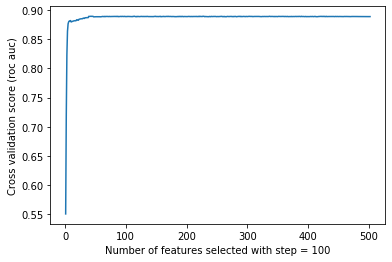

In [144]:
plt.figure()
plt.xlabel("Number of features selected with step = 100")
plt.ylabel("Cross validation score (roc auc)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [130]:
X_train_rfecv = selector.transform(X_train)

In [136]:
rfecv_predictions = selector.predict_proba(X_test)[:, 1]

In [137]:
write_to_submission_file(rfecv_predictions, 'Predictions/rfecv_predictions.csv')

In [142]:
with open('Data/RFECV/X_train_rfecv100.pkl', 'wb') as file:
    pickle.dump(X_train_rfecv, file)

In [143]:
with open('Data/RFECV/selected_features_rfecv100.pkl', 'wb') as file:
    pickle.dump(rfecv_features , file)